# Formula 1 Track Random Walk

This notebook presents an idea that was done purely for fun: combine random sectors from various tracks in new and interesting ways.  Originally this idea was to to use each sector effectively as the step in a random walk, but I found it more interesting to look at the output of such combinations as possible tracks. 

The implementation is not particularly complicated, so there is no considering for a track closing (being a complete circuit).  As such the generated tracks should be considered moreso as rally stages or hill-climbs, with distinct starts and finishes.

In [4]:
# Imports
import os
import sys
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm

import fastf1
import fastf1.plotting
fastf1.Cache.enable_cache(os.environ['f1_cache'])  
fastf1.plotting.setup_mpl()
from matplotlib.backends.backend_pdf import PdfPages
sys.path.append(os.environ['f1_install'])
from examples.f1_track_random_walk import *

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Reset plotting params from fastf1.
from IPython.utils import io
from matplotlib import rcParams, rcParamsDefault
rcParams.update(rcParamsDefault)
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.ion()


In [5]:
# Define parameters for which to produce the tracks.

year = 2022 # The year to pull track data from

selected_sectors = None#[1,2,3]#[1,1,1] # The sectors to include, None = All
selected_events = None#[0,0,0]#[0,1,2] # The sectors to include, None = All
limit_sectors = 1000 # The maximum number of sectors to be considered (helpful for debugging).

# Get relevant sector information
sector_dict = getSectorDict(year, limit_sectors=limit_sectors, selected_events=selected_events, selected_sectors=selected_sectors)

# Determine order to append sectors
sector_order = np.random.choice(list(sector_dict.keys()), size=len(sector_dict.keys()), replace=False)

# Split into smaller tracks for fun, each 6 sectors long
sector_orders = np.reshape(sector_order,(-1,6))

core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v2.3.0]
api            INFO 	Using cached data for driver_info


Selecting sectors.
Using events/sectors:  [(15, 1), (7, 2), (20, 1), (21, 3), (18, 3), (4, 3), (15, 3), (18, 1), (21, 2), (10, 3), (17, 3), (9, 3), (18, 2), (16, 1), (3, 3), (19, 3), (8, 1), (8, 2), (9, 2), (4, 2), (6, 3), (14, 1), (12, 3), (9, 1), (12, 2), (7, 3), (5, 3), (1, 3), (6, 2), (1, 1), (7, 1), (17, 1), (13, 3), (4, 1), (13, 1), (8, 3), (14, 3), (13, 2), (5, 2), (20, 2), (0, 2), (6, 1), (0, 1), (0, 3), (19, 1), (16, 2), (15, 2), (19, 2), (3, 2), (17, 2), (11, 3), (20, 3), (14, 2), (10, 1), (16, 3), (3, 1), (11, 2), (21, 1), (10, 2), (12, 1), (2, 3), (1, 2), (2, 1), (2, 2), (5, 1), (11, 1)]


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '1', '55', '11', '44', '77', '20', '14', '63', '10', '31', '47', '4', '23', '24', '22', '27', '3', '18', '6']
core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api           

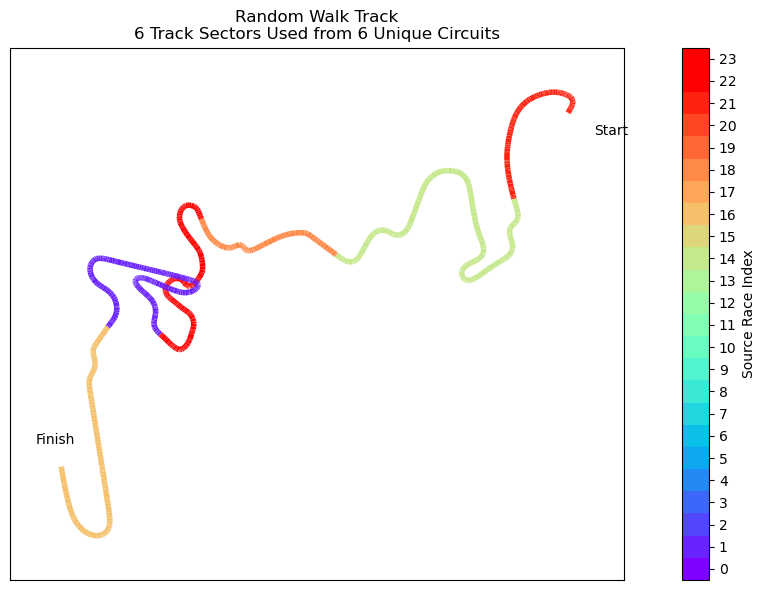

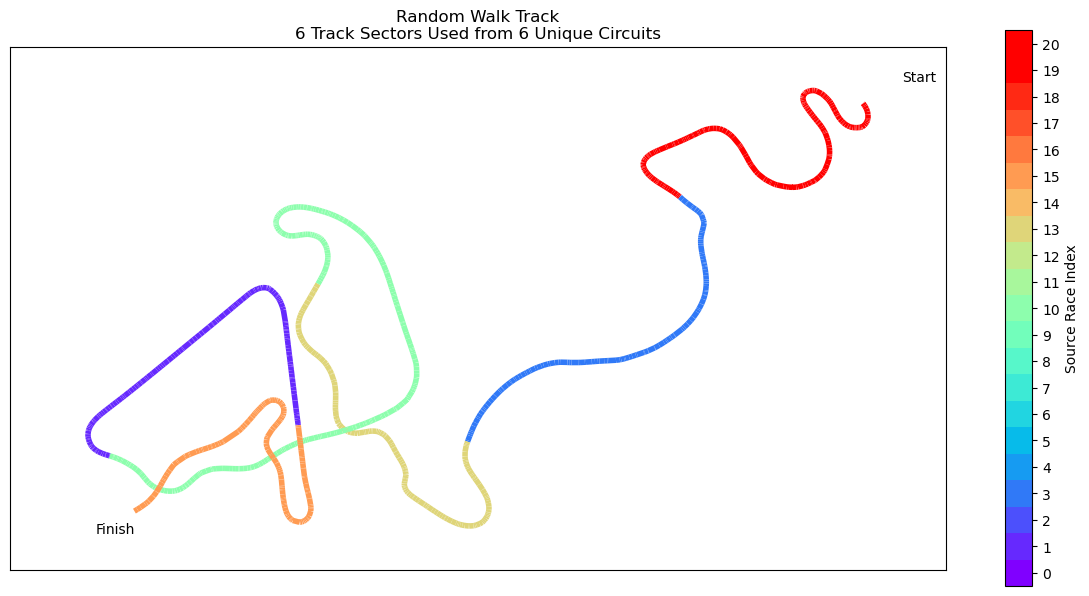

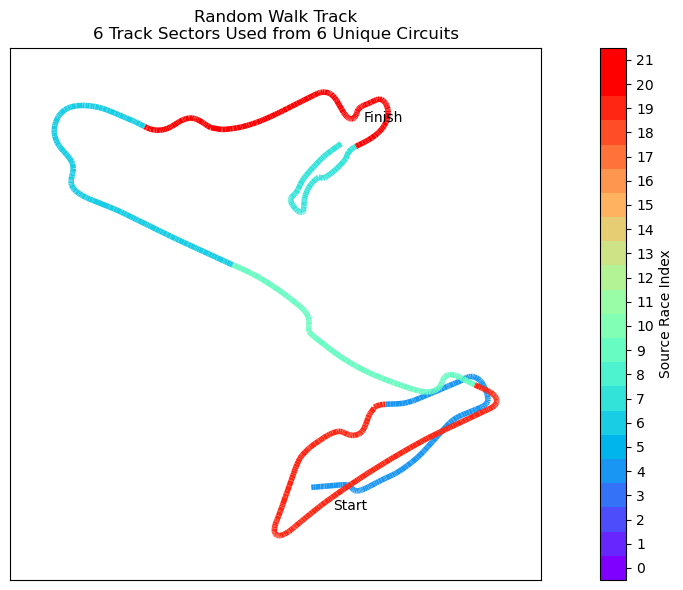

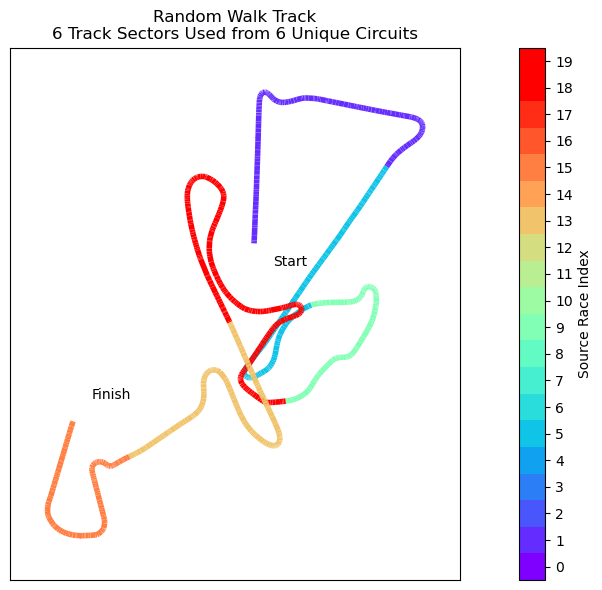

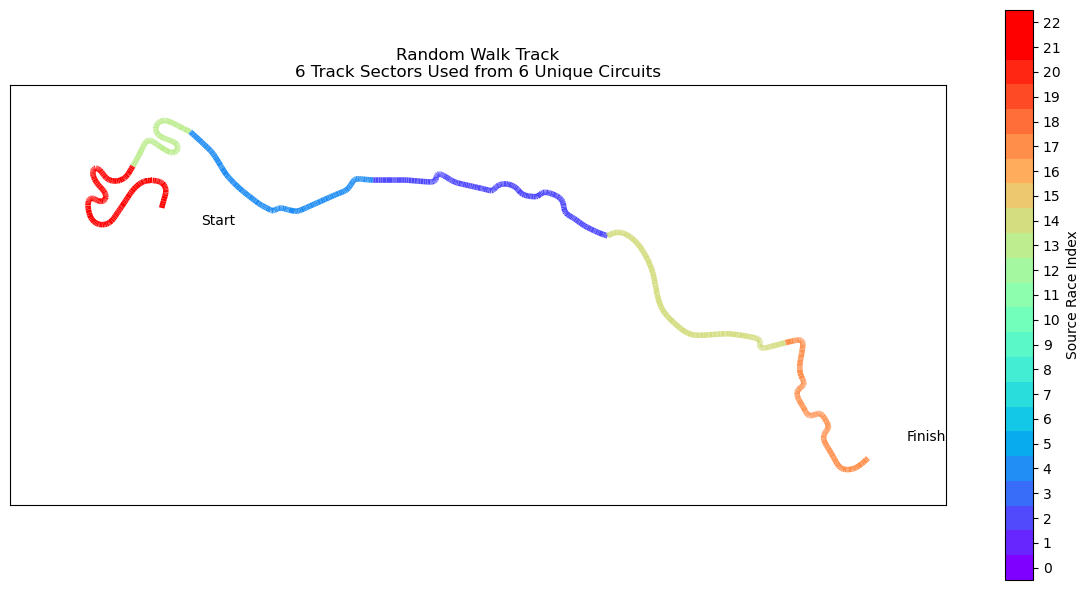

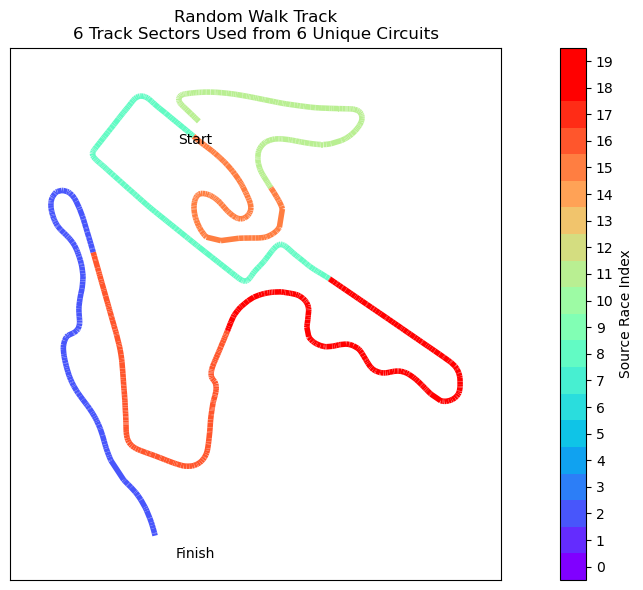

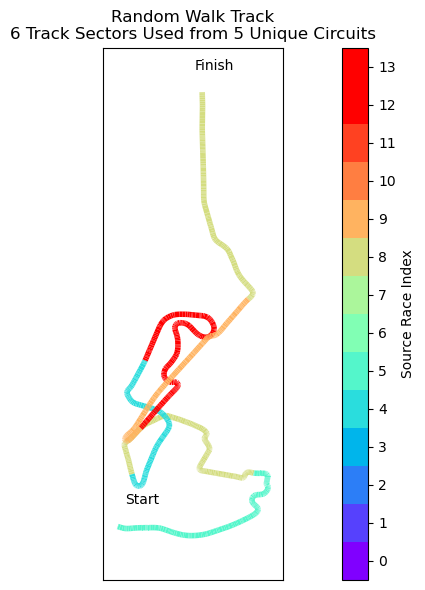

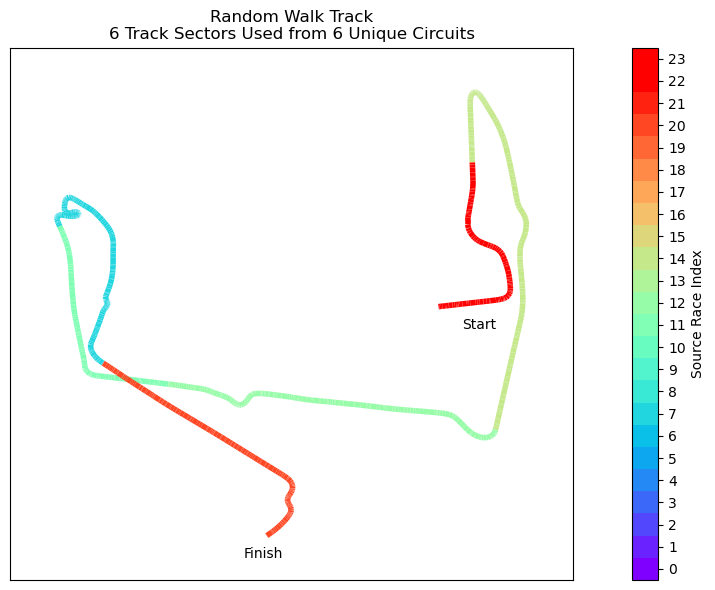

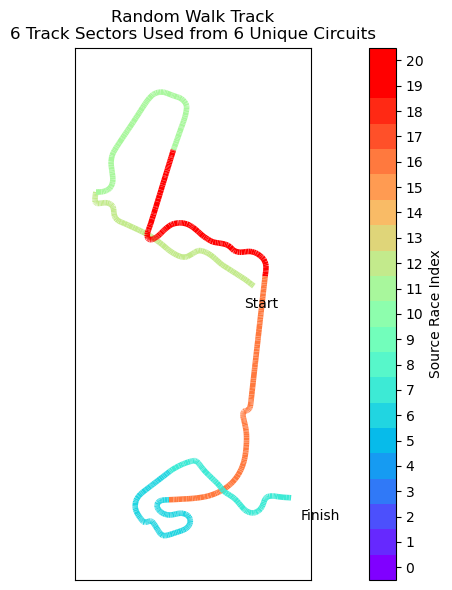

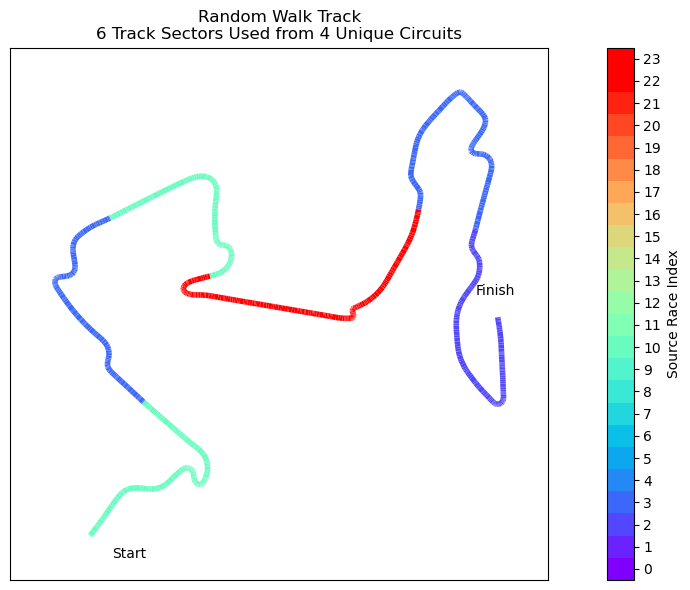

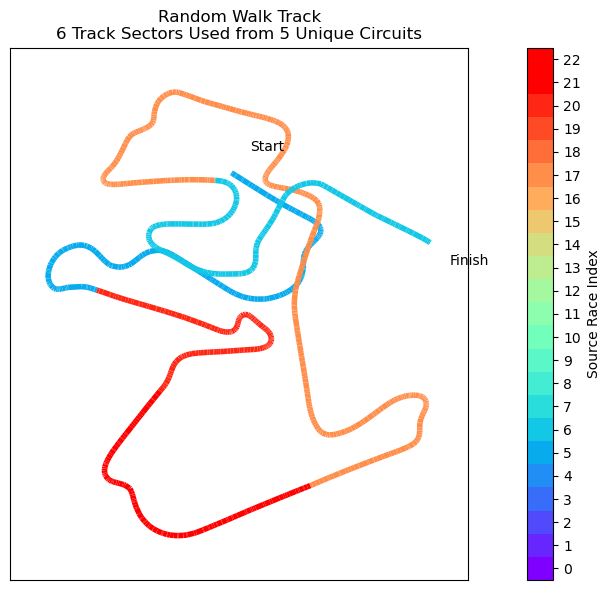

In [6]:
# Loop over sectors to generate tracks

for generated_track_index, sector_order in enumerate(sector_orders):
    # Loop over sectors, transform and append them to end of track.
    for i, sector_index in enumerate(sector_order):
        #Ignoring rotations right now, but ultimately want to align segments to flow. 
        if i == 0:
            # Initiate coordinates and colors. 
            x_all = sector_dict[sector_order[i]]['points'][:,:,0] - sector_dict[sector_order[i]]['points'][:,:,0][0] # Align end point to origin
            y_all = sector_dict[sector_order[i]]['points'][:,:,1] - sector_dict[sector_order[i]]['points'][:,:,1][0] # Align end point to origin
            c = np.ones(len(sector_dict[sector_order[i]]['points'][:,:,0]))*(sector_dict[sector_index]['event_index'] + 1)
            
        else:
            # Obtain untransformed new sector coordinates.  
            x_new = sector_dict[sector_order[i]]['points'][:,:,0] - sector_dict[sector_order[i]]['points'][:,:,0][0] # Align initial point to origin
            y_new = sector_dict[sector_order[i]]['points'][:,:,1] - sector_dict[sector_order[i]]['points'][:,:,1][0] # Align initial point to origin
            
            # Obtain track direction vectors for connecting points
            old_vector = np.array([x_all[-1] , y_all[-1]]) - np.array([x_all[-2] , y_all[-2]])
            old_vector = old_vector.flatten()/np.linalg.norm(old_vector)
            
            new_vector = np.array([x_new[1] , y_new[1]]) - np.array([x_new[0] , y_new[0]])
            new_vector = new_vector.flatten()/np.linalg.norm(new_vector)

            # Calculate angle between vectors, calculate rotation matrix values, rotate      
            angle_rad = np.arctan2( new_vector[0]*old_vector[1] - new_vector[1]*old_vector[0], new_vector[0]*old_vector[0] + new_vector[1]*old_vector[1] )
            cos, sin = np.cos(angle_rad), np.sin(angle_rad)

            x_rotated = cos * x_new - sin * y_new + x_all[-1] # Rotate and shift to end of track
            y_rotated = sin * x_new + cos * y_new + y_all[-1] # Rotate and shift to end of track

            if False:
                # Sector by sector plotting for debugging.  Shows appending of sectors, and vectors. 
                fig = plt.figure()
                
                plt.plot(x_all, y_all, c='b',label='Previous Sectors')
                plt.quiver(x_all[-1], y_all[-1], old_vector[0], old_vector[1], color='b', label='Ending Vector for Previous Sectors')
                
                plt.plot(x_new + x_all[-1], y_new + y_all[-1], c='g',label='Sector %i'%(sector_order[i]))
                plt.quiver(x_new[0] + x_all[-1],  y_new[0] + y_all[-1], new_vector[0], new_vector[1], color='g', label='Beginning Vector for Sector %i'%(sector_order[i]))
                
                plt.plot(x_rotated, y_rotated, c='r',label='Rotated Sector %i'%(sector_order[i]))

                plt.legend()

                plt.show(fig)
            
            # Append
            x_all = np.append(x_all, x_rotated)
            y_all = np.append(y_all, y_rotated)
            c = np.append(c, np.ones(len(sector_dict[sector_order[i]]['points'][:,:,0]))*(sector_dict[sector_index]['event_index'] + 1))
            
    # Reshape points for segment calculation.
    points = np.array([x_all, y_all]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Plot
    fig = plt.figure()
    ax = plt.gca()
    plt.axis('equal')
    plt.title('Random Walk Track\n{} Track Sectors Used from {} Unique Circuits'.format(len(sector_order), len(np.unique(c))))

    cmap = cm.get_cmap('rainbow')
    norm = plt.Normalize(vmin=0, vmax=max(c))
    lc_comp = LineCollection(segments, norm=norm, cmap=cmap)
    lc_comp.set_array(c)
    lc_comp.set_linewidth(4)

    plt.gca().add_collection(lc_comp)
    ax.set_aspect('equal', 'box')
    plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)

    cbar = plt.colorbar(mappable=lc_comp, label="Source Race Index", boundaries=np.arange(-0.5, max(c) + 2))
    cbar.set_ticks(np.arange(0, max(c) + 2))

    
    # Label start and finish locations

    x_range = max(x_all) - min(x_all)
    y_range = max(y_all) - min(y_all)
    plt.xlim(min(x_all)-0.1*x_range, max(x_all)+0.1*x_range)
    plt.ylim(min(y_all)-0.1*y_range, max(y_all)+0.1*y_range)

    if x_all[0] > x_all[1]:
        x_offset = -0.05*x_range
    else:
        x_offset = 0.05*x_range
    
    if y_all[0] > y_all[1]:
        y_offset = 0.05*y_range
    else:
        y_offset = -0.05*y_range
        
    plt.annotate('Start', (x_all[0], y_all[0]), (x_all[0] + x_offset, y_all[0] + y_offset), xycoords='data')


    if x_all[-2] > x_all[-1]:
        x_offset = -0.05*x_range
    else:
        x_offset = 0.05*x_range

    if y_all[-2] > y_all[-1]:
        y_offset = -0.05*y_range
    else:
        y_offset = 0.05*y_range
        
    plt.annotate('Finish', (x_all[-1], y_all[-1]), (x_all[-1] + x_offset, y_all[-1] + y_offset), xycoords='data')
    plt.tight_layout()
    fig.savefig(os.path.join(os.environ['f1_install'], 'examples', 'combined_tracks', 'combined_track_{}.svg'.format(generated_track_index)), transparent=False)

filename = os.path.join(os.environ['f1_install'], 'examples', 'combined_tracks', 'combined_track_all.pdf')
save_multi_image(filename)
